In [1]:
!pip install kaggle

In [2]:
!pip install pyspark

In [3]:
!pip install sparknlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.3/743.3 kB 7.6 MB/s eta 0:00:00


In [5]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p /content/

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 95% 1.00G/1.06G [00:07<00:01, 42.8MB/s]
100% 1.06G/1.06G [00:07<00:00, 146MB/s] 


In [8]:
!unzip /content/amazon-books-reviews.zip -d /content/

Archive:  /content/amazon-books-reviews.zip
  inflating: /content/Books_rating.csv  
  inflating: /content/books_data.csv  


In [3]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_set, size, udf, col, lower, trim, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.types import ArrayType, StringType
from collections import Counter
from wordcloud import WordCloud
from pyspark.sql.window import Window
import os

In [4]:
files = os.listdir('/content/')
files


['.config',
 'books_data.csv',
 'kaggle.json',
 'amazon-books-reviews.zip',
 'Books_rating.csv',
 'sample_data']

In [1]:
!ls /content/

amazon-books-reviews.zip  Books_rating.csv  sample_data
books_data.csv		  kaggle.json


In [15]:
spark = sparknlp.start(memory="32G")

In [5]:
spark = SparkSession.builder.appName("MarketBasketAnalysis").getOrCreate()

In [6]:
csv_file_path = "/content/Books_rating.csv"

db = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csv_file_path)
db.show(5, truncate=False)

+----------+------------------------------+-----+--------------+--------------------------------------+------------------+------------+-----------+-----------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
db.count()

3000000

In [ ]:
null_count = db.filter(db["review/text"].isNull()).count()
null_title= db.filter(db["Title"].isNull()).count()
if null_count > 0:
    print(f"There are {null_count} rows with null values in the 'review/text' column.")
else:
    print("There are no null values in the 'review/text' column.")

if null_title > 0:
    print(f"There are {null_title} rows with null values in the 'title' column.")
else:
    print("There are no null values in the 'title' column.")

There are 43 rows with null values in the 'review/text' column.
There are 208 rows with null values in the 'title' column.


In [ ]:
duplicate_count = db.count() - db.dropDuplicates().count()

if duplicate_count > 0:
    print(f"There are {duplicate_count} duplicate rows in the dataset.")
else:
    print("There are no duplicate rows in the dataset.")

There are 8865 duplicate rows in the dataset.


In [7]:
db_notnull_filter = (
    db.filter(db["review/text"].isNotNull())
      .filter(db["Title"].isNotNull())
      .dropDuplicates()
)

df = db_notnull_filter.sample(withReplacement=False, fraction=0.001, seed=42)

print("Sample baskets:", df.count())
df.show(5, truncate=False)

Sample baskets: 2988
+----------+------------------------------------------------------------------------------------------------------------------------+-----+--------------+------------------+------------------+------------+-----------+-----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id        |Title                        

In [26]:
tokenizer = Tokenizer(inputCol="review/text", outputCol="words")
df_words = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_cleaned = remover.transform(df_words)

remove_duplicates_udf = udf(lambda words: list(set(words)), ArrayType(StringType()))
def clean_words(words):
    if not words:
        return []
    return [re.sub(r'[^a-zA-Z]', '', w).lower() for w in words if isinstance(w, str) and re.sub(r'[^a-zA-Z]', '', w)]

remove_punctuations_udf = udf(clean_words, ArrayType(StringType()))

df_cleaned = df_cleaned.withColumn("filtered_words", remove_punctuations_udf(col("filtered_words")))

df_cleaned = df_cleaned.withColumn("filtered_words", remove_duplicates_udf(df_cleaned["filtered_words"]))

from pyspark.sql.functions import size
df_cleaned = df_cleaned.filter(size("filtered_words") > 0)

df_cleaned.select("filtered_words").distinct().show(truncate=False)
df_cleaned = df_cleaned.repartition(8)

fp_growth = FPGrowth(itemsCol="filtered_words", minSupport=0.01, minConfidence=0.2)
model = fp_growth.fit(df_cleaned)

model.freqItemsets.show()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

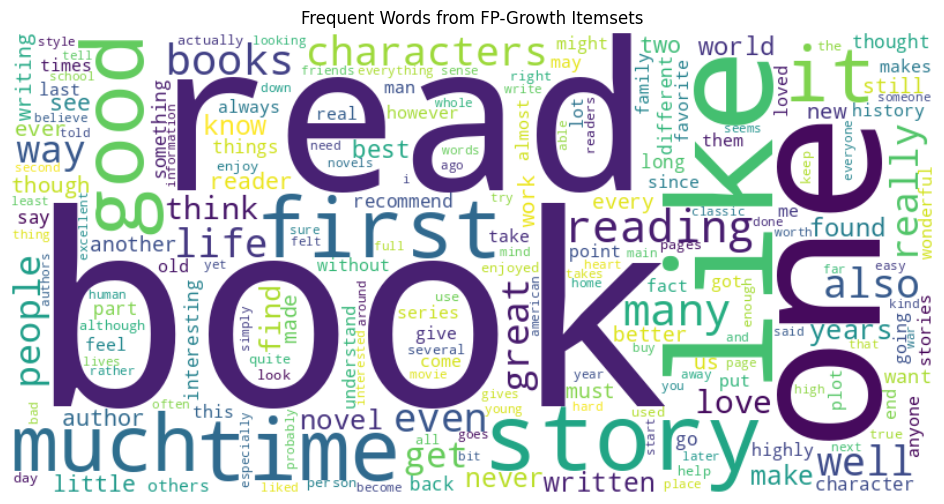

In [27]:
top_itemsets = model.freqItemsets.orderBy("freq", ascending=False).toPandas()


word_counts = Counter()
for items, freq in zip(top_itemsets['items'], top_itemsets['freq']):
    for word in items:
        word_counts[word] += freq


wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate_from_frequencies(word_counts)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Frequent Words from FP-Growth Itemsets")
plt.show()


/tmp/ipython-input-2690497631.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="itemset", x="freq", data=top_itemsets_barchart, palette="viridis")


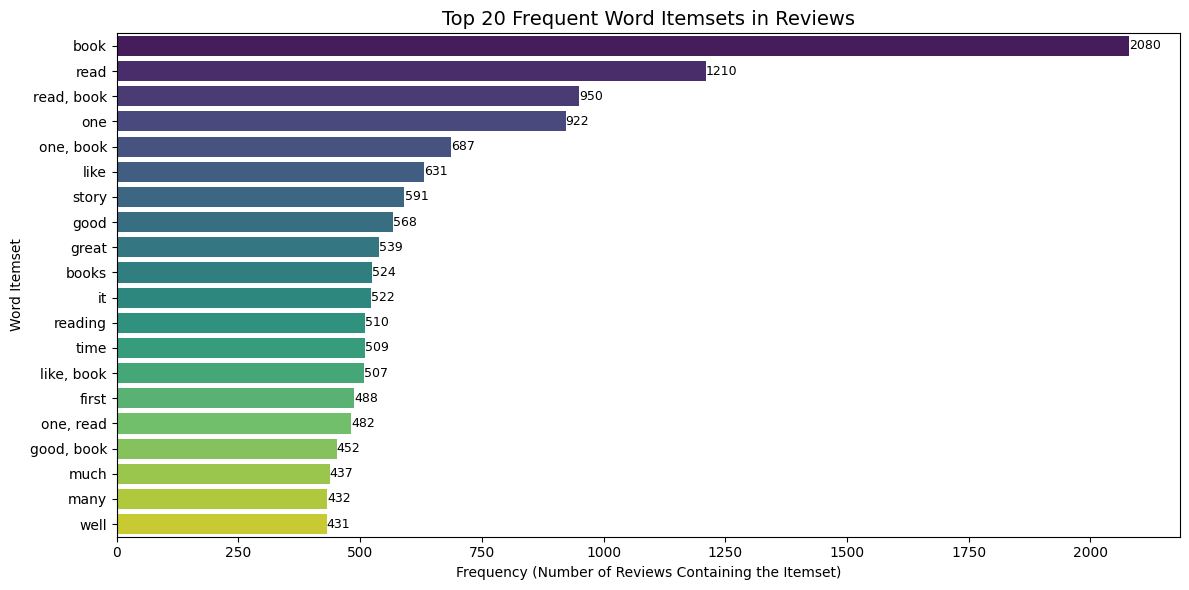

In [28]:
top_itemsets_barchart = model.freqItemsets.orderBy("freq", ascending=False).limit(20).toPandas()
top_itemsets_barchart["itemset"] = top_itemsets_barchart["items"].apply(lambda x: ", ".join(x))

plt.figure(figsize=(12, 6))
sns.barplot(y="itemset", x="freq", data=top_itemsets_barchart, palette="viridis")

for i, v in enumerate(top_itemsets_barchart["freq"]):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=9)

plt.title("Top 20 Frequent Word Itemsets in Reviews", fontsize=14)
plt.xlabel("Frequency (Number of Reviews Containing the Itemset)")
plt.ylabel("Word Itemset")
plt.tight_layout()
plt.show()

In [29]:
top_itemsets

,items,freq
0,[book],2080
1,[read],1210
2,"[read, book]",950
3,[one],922
4,"[one, book]",687
...,...,...
12440,"[life, good, one, read]",30
12441,"[life, good, like, book]",30
12442,"[life, well, much]",30
12443,"[ideas, one, book]",30


In [30]:
model.associationRules.show()

+------------+----------+-------------------+------------------+--------------------+
|  antecedent|consequent|         confidence|              lift|             support|
+------------+----------+-------------------+------------------+--------------------+
|[think, one]|  [really]|0.24812030075187969|1.8014379013226496|0.011058981233243968|
|[think, one]|      [it]| 0.3233082706766917|1.8481836775847664|0.014410187667560321|
|[think, one]|   [first]| 0.3082706766917293|1.8849993837051644|0.013739946380697051|
|[think, one]|    [even]| 0.3458646616541353|2.8045112781954886|0.015415549597855228|
|[think, one]|    [read]| 0.6240601503759399|1.5390045361337228| 0.02781501340482574|
|[think, one]|    [book]| 0.8947368421052632|1.2836032388663967| 0.03987935656836461|
|[think, one]|    [good]| 0.3007518796992481|1.5800063539129514|0.013404825737265416|
|[think, one]|    [well]| 0.3007518796992481| 2.082235751792474|0.013404825737265416|
|[think, one]|    [many]| 0.2857142857142857|1.9735449

### ***Considering books as items***

In [8]:
df_user_books = db_notnull_filter.dropna(subset=["User_id", "Id"]).dropDuplicates().groupBy("User_id") \
    .agg(collect_set("Id").alias("books"))

#Keep only users who reviewed more than one book
df_user_books = df_user_books.filter(size("books") > 1)



In [9]:
df_user_books.show(10, truncate=False)

+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User_id                                                           |books                                                                                                                                                                                                                                                                                           |
+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
df_user_books_sample = df_user_books.sample(withReplacement=False, fraction=0.01, seed=42)
df_user_books_sample = df_user_books_sample.filter(size("books") > 1)

In [11]:
fp_growth = FPGrowth(itemsCol="books", minSupport=0.001, minConfidence=0.1)
model = fp_growth.fit(df_user_books_sample)

In [12]:
model.freqItemsets.orderBy(F.col("freq").desc()).show(10, truncate=False)

+------------------------------------------------+----+
|items                                           |freq|
+------------------------------------------------+----+
|[B000GQG7D2]                                    |37  |
|[B000ILIJE0]                                    |37  |
|[B000GQG7D2, B000NWU3I4]                        |37  |
|[B000ILIJE0, B000GQG7D2]                        |37  |
|[B000ILIJE0, B000GQG7D2, B000NWU3I4]            |37  |
|[B000ILIJE0, B000NWU3I4]                        |37  |
|[B000NWU3I4]                                    |37  |
|[B000GQG5MA, B000GQG7D2]                        |36  |
|[B000H9R1Q0, B000Q032UY]                        |36  |
|[B000PC54NG, B000Q032UY, B000ILIJE0, B000GQG7D2]|36  |
+------------------------------------------------+----+
only showing top 10 rows



In [13]:
model.associationRules.show()

+--------------------+------------+----------+------+--------------------+
|          antecedent|  consequent|confidence|  lift|             support|
+--------------------+------------+----------+------+--------------------+
|[0140860282, 0134...|[068199570X]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[B0006AQ4LI]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[0606015825]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[1582790337]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[B0006BV6RY]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[B000P4Q3JS]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[B000FFQ85G]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[1593351348]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[0395051029]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[0451521196]|       1.0|791.75|0.001263024944742...|
|[0140860282, 0134...|[04

In [14]:
db_notnull_filter_clean = (db_notnull_filter.select("Id", "Title").withColumn("Title_clean",F.trim(F.regexp_replace(F.lower(F.col("Title")),r"\s+", " "))))

titles_df = db_notnull_filter_clean.select(
    F.col("Id").cast("string"),
    F.col("Title_clean")
).dropna(subset=["Id", "Title_clean"])


title_freqs = titles_df.groupBy("Id", "Title_clean").agg(F.count("*").alias("title_count"))

best_titles = (
    title_freqs
    .withColumn(
        "rank",
        F.row_number().over(
            Window.partitionBy("Id").orderBy(F.desc("title_count"), F.length("Title_clean"))
        )
    )
    .filter(F.col("rank") == 1)
    .select("Id", "Title_clean")
)

id2title = {row["Id"]: row["Title_clean"] for row in best_titles.collect()}


In [15]:
def format_items(ids):
    seen_titles = {}
    formatted = []
    for book_id in ids:
        title = id2title.get(book_id, str(book_id)).strip()
        if title in seen_titles:
            suffix = f" [{str(book_id)[-4:]}]"
            formatted.append(title + suffix)
        else:
            formatted.append(title)
            seen_titles[title] = 1
    return formatted


Single-item itemsets (rows): 769
Top books (after grouping): 15


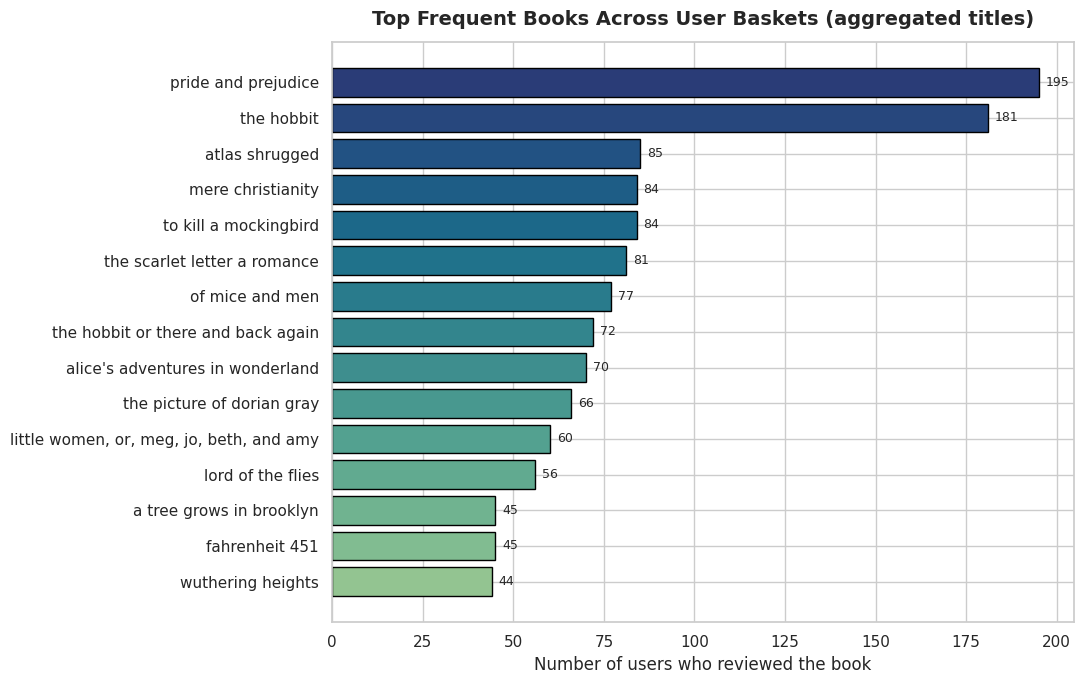

In [16]:
freq_df = model.freqItemsets.orderBy(F.col("freq").desc()).toPandas()

singles = freq_df[freq_df["items"].apply(lambda x: len(x) == 1)].copy()
print("Single-item itemsets (rows):", len(singles))

singles["raw_title"] = singles["items"].apply(lambda x: id2title.get(x[0], str(x[0])))

def normalize_title(s):
    s = str(s).lower().strip()
    s = re.sub(r'[^0-9a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

singles["title_norm"] = singles["raw_title"].apply(normalize_title)

agg = (
    singles
    .groupby("title_norm", as_index=False)
    .agg(freq=("freq", "sum"), display_title=("raw_title", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]))
)

def shorten_title(t, max_len=70):
    t = str(t)
    return t if len(t) <= max_len else t[:max_len-3] + "..."

agg["display_title_short"] = agg["display_title"].apply(lambda t: shorten_title(t, max_len=70))

top_n = 15
top_books = agg.nlargest(top_n, "freq").iloc[::-1]
print("Top books (after grouping):", top_books.shape[0])

plt.figure(figsize=(11, 7))
sns.set(style="whitegrid")
colors = sns.color_palette("crest", len(top_books))

bars = plt.barh(top_books["display_title_short"], top_books["freq"], color=colors, edgecolor="black")

max_freq = top_books["freq"].max() if not top_books["freq"].empty else 0
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width + max_freq * 0.01, y, f"{int(width):,}", va='center', fontsize=9)

plt.title("Top Frequent Books Across User Baskets (aggregated titles)", fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Number of users who reviewed the book", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()


Number of 2-item itemsets (rows): 2213
Top pairs (after grouping): 20


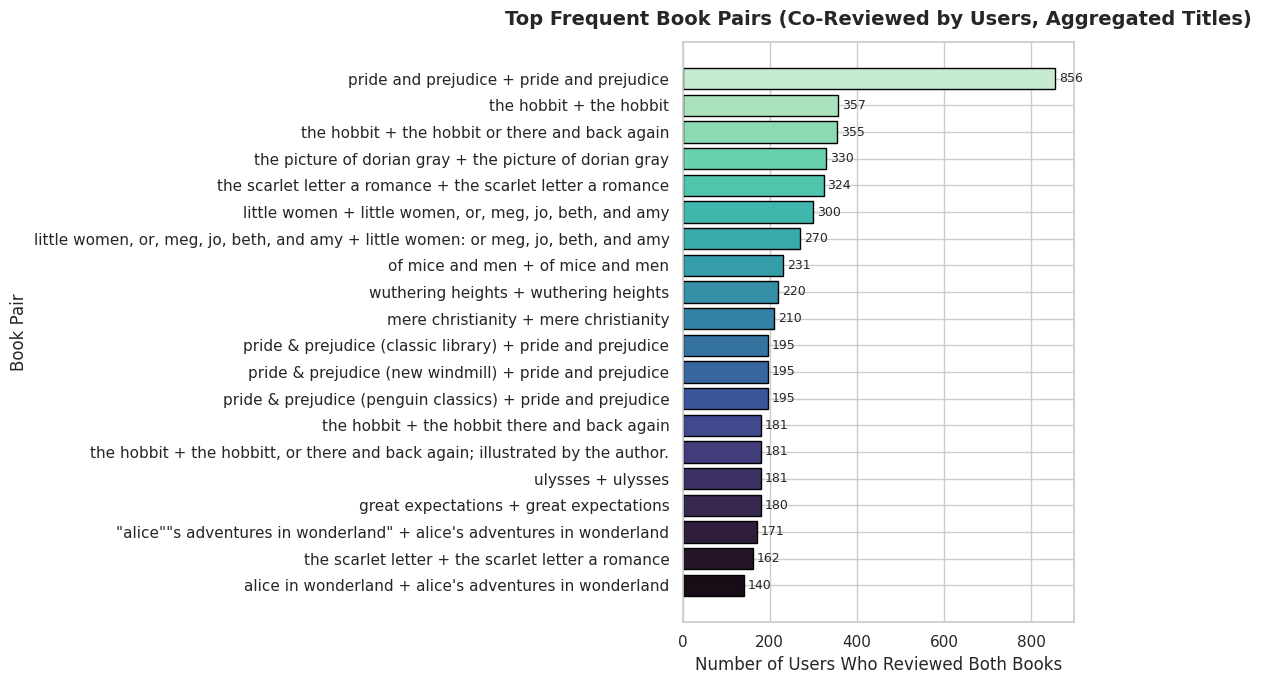

In [17]:
pairs = freq_df[freq_df["items"].apply(lambda x: len(x) == 2)].copy()
print("Number of 2-item itemsets (rows):", len(pairs))

pairs["book1_raw"] = pairs["items"].apply(lambda x: id2title.get(x[0], str(x[0])))
pairs["book2_raw"] = pairs["items"].apply(lambda x: id2title.get(x[1], str(x[1])))

pairs["book1_norm"] = pairs["book1_raw"].apply(normalize_title)
pairs["book2_norm"] = pairs["book2_raw"].apply(normalize_title)

pairs["pair_norm"] = pairs.apply(
    lambda row: " + ".join(sorted([row["book1_norm"], row["book2_norm"]])), axis=1
)
pairs["pair_display"] = pairs.apply(
    lambda row: " + ".join(sorted([row["book1_raw"], row["book2_raw"]])), axis=1
)

agg_pairs = (
    pairs
    .groupby("pair_norm", as_index=False)
    .agg(freq=("freq", "sum"),
         display_pair=("pair_display", lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]))
)

top_n_pairs = 20
top_pairs = agg_pairs.nlargest(top_n_pairs, "freq").iloc[::-1]
print("Top pairs (after grouping):", top_pairs.shape[0])

plt.figure(figsize=(11, 7))
sns.set(style="whitegrid")
colors = sns.color_palette("mako", len(top_pairs))

bars = plt.barh(top_pairs["display_pair"], top_pairs["freq"], color=colors, edgecolor="black")

max_freq = top_pairs["freq"].max() if not top_pairs["freq"].empty else 0
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width + max_freq * 0.01, y, f"{int(width):,}", va='center', fontsize=9)

plt.title("Top Frequent Book Pairs (Co-Reviewed by Users, Aggregated Titles)",
          fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Number of Users Who Reviewed Both Books", fontsize=12)
plt.ylabel("Book Pair", fontsize=12)
plt.tight_layout()
plt.show()
